In [1]:
device='cuda:1'

In [2]:
run config

In [3]:
import numpy as np
from tqdm.notebook import tqdm
import os

from include import * 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tensorflow import summary
import tensorflow as tf

In [4]:
##Load paths 
clean_train= data_path + 'clean_train/'
noisy_train= data_path + 'noisy_train/'

clean_val= data_path + 'clean_val/'
noisy_val= data_path + 'noisy_val/'

In [5]:
##Prepare data
class data():
    
    def __init__(self, path_clean, path_noisy):
        self.path_clean = path_clean
        self.path_noisy = path_noisy
        
    def __len__(self):
        return len(os.listdir(self.path_clean))
    
    def __getitem__(self, idx):
        
        data= dict()
        data['clean']= torch.load(self.path_clean + '{0:05}'.format(idx))
        data['noisy']= torch.load(self.path_noisy + '{0:05}'.format(idx))

        return data


In [6]:
training_set=data(clean_train, noisy_train)
validation_set=data(clean_val, noisy_val)

t_split= 4000
t_diff= len(training_set)-t_split

v_split= 100
v_diff= len(validation_set)-v_split


train_set, nth= torch.utils.data.random_split(training_set,[t_split,t_diff])
val_set,   nth= torch.utils.data.random_split(validation_set,[v_split,v_diff])

#Dataloader
train_dl = DataLoader(train_set, batch_size=16, shuffle=True)
val_dl = DataLoader(val_set, batch_size=1, shuffle=False)


In [7]:
model = Unet_Mixer_analysis4().to(device)   

In [8]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

6528000

In [9]:
##Functions

##Loss
def mse(gt: torch.Tensor, pred:torch.Tensor)-> torch.Tensor:
    loss = torch.nn.MSELoss()
    return loss(gt,pred)

#train
def train(model, optimizer, sample):
    model.train()
    
    # reset optimizer's gradient
    optimizer.zero_grad()

    # define input and output
    clean = sample['clean'].to(device)
    noisy = sample['noisy'].to(device)
      
    # get the prediction
    pred = model(noisy)
    img = torch.clamp(noisy-pred, 0, 1)
    pred_loss = mse(img, clean)
    
    #one step of training
    pred_loss.backward()
    optimizer.step()

    return pred_loss.item()

#test function
def test(model, sample): 
    model.eval()
    
    with torch.no_grad(): 
        
        # define input and output
        clean = sample['clean'].to(device)
        noisy = sample['noisy'].to(device)
        
        # get the prediction
        pred = model(noisy)
        img = torch.clamp(noisy-pred, 0, 1)
        pred_loss = mse(img, clean)

    return pred_loss.item()

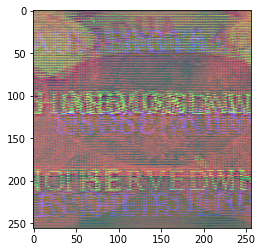

In [22]:
from matplotlib import pyplot as plt
plt.imshow(sample['clean'][0].permute(1,2,0))

In [19]:
sample['clean'][0].permute(1,2,0)

tensor([[[0.7137, 0.4549, 0.4471],
         [0.6314, 0.4667, 0.3451],
         [0.6275, 0.5059, 0.4157],
         ...,
         [0.6863, 0.5882, 0.3216],
         [0.6118, 0.6863, 0.3804],
         [0.7137, 0.7255, 0.4078]],

        [[0.7255, 0.6196, 0.4039],
         [0.6118, 0.6902, 0.4863],
         [0.5451, 0.7137, 0.5608],
         ...,
         [0.7843, 0.3647, 0.4510],
         [0.4627, 0.4471, 0.5373],
         [0.5961, 0.4667, 0.3804]],

        [[0.7020, 0.3922, 0.4431],
         [0.5255, 0.4431, 0.5333],
         [0.6118, 0.5059, 0.3804],
         ...,
         [0.8431, 0.5176, 0.4627],
         [0.8000, 0.4471, 0.3373],
         [0.7294, 0.5176, 0.4118]],

        ...,

        [[0.4353, 0.4549, 0.4000],
         [0.3725, 0.3373, 0.4902],
         [0.4706, 0.4078, 0.5529],
         ...,
         [0.6118, 0.3098, 0.4275],
         [0.6941, 0.3686, 0.4980],
         [0.7255, 0.3961, 0.3529]],

        [[0.6431, 0.4078, 0.4157],
         [0.6902, 0.4902, 0.4784],
         [0.

In [10]:
#prepare tensorboard
train_log_dir = logs_path + 'mixer_analysis4_4000/train'
train_summary_writer = summary.create_file_writer(train_log_dir)
val_log_dir = logs_path + 'mixer_analysis4_4000/validate'
val_summary_writer = summary.create_file_writer(val_log_dir)

In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.0007, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [ ]:
max_epoch = 150
least_loss = 9999
tmp_path= models_path  +'temp_mixer_analysis4_4000.pth'
best_path= models_path +'best_mixer_analysis4_4000.pth'

for epoch in tqdm(range(max_epoch)):
    # Initialize Loss and Accuracy
    train_loss = val_loss= 0.0
    
###############################################################################################################  
                                             ###Train Phase
    
    ## Iterate over the train_dataloader
    with tqdm(total=len(train_dl)) as pbar:
        for sample in train_dl:            
            curr_loss = train(model, optimizer, sample)
            train_loss += curr_loss / len(train_dl) 
            pbar.update(1)
    
    scheduler.step()
    
    ## Write the current loss to Tensorboard
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step=epoch)                
        
###############################################################################################################
   
    ## save the model and optimizer's information as a checkpoint
    checkpoint = {
         'model_state_dict': model.state_dict(),
         'optimizer_state_dict': optimizer.state_dict()}
    torch.save(checkpoint, tmp_path)

###############################################################################################################
                                             ###Validate Phase 
    
    ## Iterate over the test_dataloader
    with tqdm(total=len(val_dl)) as pbar:
        for sample in val_dl: 
            curr_loss= test(model, sample)
            val_loss += curr_loss / len(val_dl)
            pbar.update(1)
        
    ## Write the current loss and accuracy to the Tensorboard
    with val_summary_writer.as_default():
        tf.summary.scalar('loss', val_loss, step=epoch)
           
############################################################################################################### 
    
    print(epoch, train_loss, val_loss)
    
    ##Save best model
    least_loss = min(val_loss, least_loss)
    if least_loss == val_loss:
        torch.save(checkpoint, best_path)